In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
import re
import json
from glob import glob
import seaborn as sns
import itertools

## Annotation DB

### define paths for annotations and audio files

In [2]:
PATH_TO_FILES = "/Users/shai/personal/deepvoice/Fish_Rach/Data/Fish_Racheli-jul10-confidence/"

files_list = list(glob(PATH_TO_FILES+'*.txt')) # ignore irrelevent files
files_list

['/Users/shai/personal/deepvoice/Fish_Rach/Data/Fish_Racheli-jul10-confidence/2up_20231114_0000_to_0019.Table.1.selections_fish.txt2.txt',
 '/Users/shai/personal/deepvoice/Fish_Rach/Data/Fish_Racheli-jul10-confidence/1up_20231114_000100to00090.Table.1.selections_0001_0009RacheliKalian.txt',
 '/Users/shai/personal/deepvoice/Fish_Rach/Data/Fish_Racheli-jul10-confidence/1up_20231114_0000_to_0009.Table.1.selections_fish.txt',
 '/Users/shai/personal/deepvoice/Fish_Rach/Data/Fish_Racheli-jul10-confidence/1up_20231114_0600_to_0609_confidence.Table.1.selections.txt',
 '/Users/shai/personal/deepvoice/Fish_Rach/Data/Fish_Racheli-jul10-confidence/10up_20231114_000000.Table.1.selections 00.00.txt final.txt',
 '/Users/shai/personal/deepvoice/Fish_Rach/Data/Fish_Racheli-jul10-confidence/20up_20231114_060000.Table.1.selections.txt',
 '/Users/shai/personal/deepvoice/Fish_Rach/Data/Fish_Racheli-jul10-confidence/7up_20231114_000000.Table.1.selectionsknoll7.txt',
 '/Users/shai/personal/deepvoice/Fish_Rac

### parse .txt file into pandas df

In [3]:
## read every tags file into a dataframe and concatenate them all into "all_data" df

all_data = pd.DataFrame()
for file in files_list:
    tmp_file = pd.read_csv(os.path.join(PATH_TO_FILES, file), sep="\t", on_bad_lines='skip')
    tmp_file['annotation_source'] = file.replace('.txt', '')
    print(f'length: {len(tmp_file)} for file: {file}')
    all_data = all_data.append(tmp_file, ignore_index=True)
print('\n',all_data.count())
all_data.head()

length: 1019 for file: /Users/shai/personal/deepvoice/Fish_Rach/Data/Fish_Racheli-jul10-confidence/2up_20231114_0000_to_0019.Table.1.selections_fish.txt2.txt
length: 809 for file: /Users/shai/personal/deepvoice/Fish_Rach/Data/Fish_Racheli-jul10-confidence/1up_20231114_000100to00090.Table.1.selections_0001_0009RacheliKalian.txt
length: 732 for file: /Users/shai/personal/deepvoice/Fish_Rach/Data/Fish_Racheli-jul10-confidence/1up_20231114_0000_to_0009.Table.1.selections_fish.txt
length: 1625 for file: /Users/shai/personal/deepvoice/Fish_Rach/Data/Fish_Racheli-jul10-confidence/1up_20231114_0600_to_0609_confidence.Table.1.selections.txt
length: 101 for file: /Users/shai/personal/deepvoice/Fish_Rach/Data/Fish_Racheli-jul10-confidence/10up_20231114_000000.Table.1.selections 00.00.txt final.txt
length: 401 for file: /Users/shai/personal/deepvoice/Fish_Rach/Data/Fish_Racheli-jul10-confidence/20up_20231114_060000.Table.1.selections.txt
length: 215 for file: /Users/shai/personal/deepvoice/Fish_Ra

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,annotation_source
0,1,Spectrogram 1,1,5.434998,5.444576,0.0,861.035,0.0096,861.035,-28.08,1,/Users/shai/personal/deepvoice/Fish_Rach/Data/...
1,2,Spectrogram 1,1,5.449800,5.458507,0.0,769.640,0.0087,769.640,-33.30,1,/Users/shai/personal/deepvoice/Fish_Rach/Data/...
2,3,Spectrogram 1,1,5.468085,5.476793,0.0,779.261,0.0087,779.261,-38.53,2,/Users/shai/personal/deepvoice/Fish_Rach/Data/...
3,5,Spectrogram 1,1,7.579577,7.593508,0.0,764.830,0.0139,764.830,-44.77,2,/Users/shai/personal/deepvoice/Fish_Rach/Data/...
4,6,Spectrogram 1,1,7.818155,7.826862,0.0,750.399,0.0087,750.399,-43.56,2,/Users/shai/personal/deepvoice/Fish_Rach/Data/...


In [4]:
all_data['Annotation'].value_counts()

2                  2535
1                  1408
f                   521
t                   112
1                    78
un                   58
2                    23
c                     7
Dolphin clicks?       1
4                     1
Name: Annotation, dtype: int64

In [5]:
def labels_alignment_old(s):  # the function we used with tagging method#1
    if s=="t" or s=="un" or s=="c": # "t" for train (chain-like) or "un" for unknown
        return "unknown"  # to avoid taking the noise there
    else:
        return "fish"
    
def labels_alignment(s):  # the function we're using for tagging method that includes confidence level
    if "1" in str(s):
        return "fish"
    return "unknown"

all_data['Annotation'] = all_data['Annotation'].apply(labels_alignment)
all_data['Annotation'].value_counts()

unknown    4347
fish       1486
Name: Annotation, dtype: int64

In [6]:
# keep only the most important fields and change the names to match the desired notation
most_important_fields = {'Begin Time (s)': 'begin_time',
                         'End Time (s)': 'end_time',
                         'Delta Time (s)': 'length',
                         'Low Freq (Hz)': 'low_freq',
                         'High Freq (Hz)': 'high_freq',
                         'Annotation': 'label',
                         'annotation_source': 'annotation_source',
                        }
df = all_data[most_important_fields.keys()]
df.columns = list(most_important_fields.values())
df['filename'] = df['annotation_source'].str.split('.').str[0]
df.count()

/Users/shai/personal/deepvoice/soundbay/.env_dv/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":


begin_time           5833
end_time             5833
length               5833
low_freq             5833
high_freq            5833
label                5833
annotation_source    5833
filename             5833
dtype: int64

### analysis

In [7]:
df['label'].value_counts()

unknown    4347
fish       1486
Name: label, dtype: int64

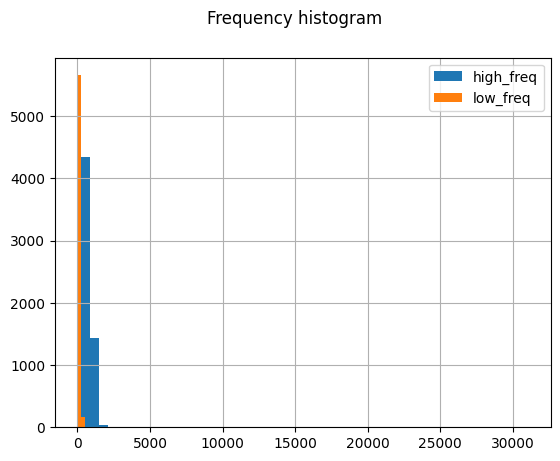

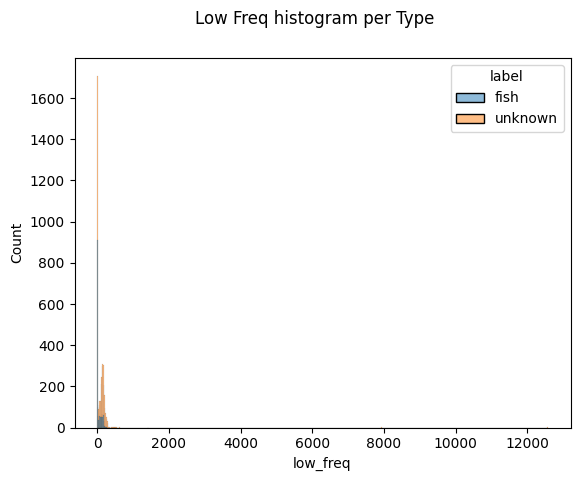

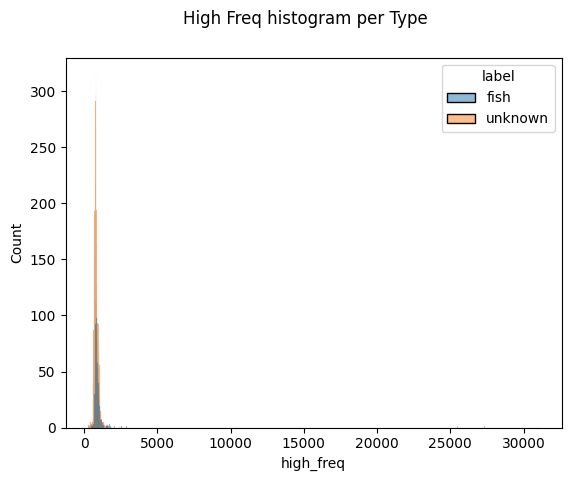

31064.935


In [8]:
# frequencies
df["high_freq"].hist(bins=50, legend=True)
df["low_freq"].hist(bins=50, legend=True)
plt.suptitle('Frequency histogram')
plt.show()

sns.histplot(df[['low_freq', 'label', 'high_freq']].reset_index(drop=True), x='low_freq', hue='label')
plt.suptitle('Low Freq histogram per Type')
plt.show()

sns.histplot(df[['low_freq', 'label', 'high_freq']].reset_index(drop=True), x='high_freq', hue='label')
plt.suptitle('High Freq histogram per Type')
plt.show()

print(max(df["high_freq"]))

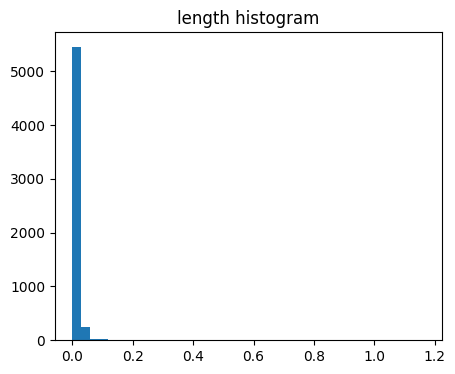

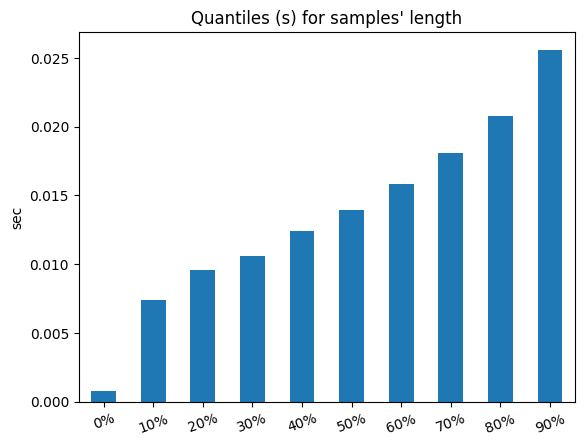

In [9]:
# lengths
plt.figure(figsize=(5,4))
plt.title('length histogram')
plt.hist(df['length'], bins=40)
plt.show()

quantile_keys = np.arange(0, 1, 0.1)
pd.Series(np.quantile(df['length'], quantile_keys), index=map(lambda x: f'{x:.0%}', quantile_keys), name='Quantiles').plot.bar()
plt.title('Quantiles (s) for samples\' length')
plt.xticks(rotation=20)
plt.ylabel('sec')
plt.show()

### add background noise

In [10]:
def multirange_diff(r1_list, r2_list):
    """Generated the difference between two time ranges"""
    for r2 in r2_list:
        r1_list = list(itertools.chain(*[range_diff(r1, r2) for r1 in r1_list]))
    return r1_list

def range_diff(r1, r2):
    s1, e1 = r1
    s2, e2 = r2
    endpoints = sorted((s1, s2, e1, e2))
    result = []
    if endpoints[0] == s1 and endpoints[1] != s1:
        result.append((endpoints[0], endpoints[1]))
    if endpoints[3] == e1 and endpoints[2] != e1:
        result.append((endpoints[2], endpoints[3]))
    return result

In [11]:
df_training = df.copy()

In [12]:
## add noise in between calls
for file in df_training['filename'].unique():
    file_length = sf.info(file + '.wav').duration
    print(f"file {os.path.basename(file)}, length: {file_length}")
    relevant_annot = df_training[df_training['filename'] == file]
    
    # Background is the subtraction of the annotated sections from the whole timerange in the file 
    bg_ranges = np.array(multirange_diff([(0, file_length)], [(relevant_annot['begin_time'].iloc[i], relevant_annot['end_time'].iloc[i]) for i in range(len(relevant_annot))])).astype(float)
    if len(bg_ranges)>1:
        # Noise exists in all channels, signal exists only in the channel it was annotated in
        bg_annot = pd.DataFrame({'begin_time': bg_ranges[:, 0], 'end_time': bg_ranges[:, 1], 'length': bg_ranges[:, 1]-bg_ranges[:, 0], 'label': ['Noise']*len(bg_ranges), 'filename':[file] * len(bg_ranges)})

        df_training = pd.concat([df_training, bg_annot], axis=0, ignore_index=True)

file 2up_20231114_0000_to_0019, length: 580.0
file 1up_20231114_000100to00090, length: 261.0
file 1up_20231114_0000_to_0009, length: 261.0
file 1up_20231114_0600_to_0609_confidence, length: 290.0
file 10up_20231114_000000, length: 290.0
file 20up_20231114_060000, length: 174.0
file 7up_20231114_000000, length: 289.0
file 2up_20231114_060000_to_06090, length: 290.0
file 10up_20231114_060000, length: 290.0


In [13]:
df_training

,begin_time,end_time,length,low_freq,high_freq,label,annotation_source,filename
0,5.434998,5.444576,0.009600,0.0,861.035,fish,/Users/shai/personal/deepvoice/Fish_Rach/Data/...,/Users/shai/personal/deepvoice/Fish_Rach/Data/...
1,5.449800,5.458507,0.008700,0.0,769.640,fish,/Users/shai/personal/deepvoice/Fish_Rach/Data/...,/Users/shai/personal/deepvoice/Fish_Rach/Data/...
2,5.468085,5.476793,0.008700,0.0,779.261,unknown,/Users/shai/personal/deepvoice/Fish_Rach/Data/...,/Users/shai/personal/deepvoice/Fish_Rach/Data/...
3,7.579577,7.593508,0.013900,0.0,764.830,unknown,/Users/shai/personal/deepvoice/Fish_Rach/Data/...,/Users/shai/personal/deepvoice/Fish_Rach/Data/...
4,7.818155,7.826862,0.008700,0.0,750.399,unknown,/Users/shai/personal/deepvoice/Fish_Rach/Data/...,/Users/shai/personal/deepvoice/Fish_Rach/Data/...
...,...,...,...,...,...,...,...,...
10750,285.334639,287.250127,1.915488,NaN,NaN,Noise,NaN,/Users/shai/personal/deepvoice/Fish_Rach/Data/...
10751,287.265678,288.187981,0.922303,NaN,NaN,Noise,NaN,/Users/shai/personal/deepvoice/Fish_Rach/Data/...
10752,288.203029,289.856746,1.653717,NaN,NaN,Noise,NaN,/Users/shai/personal/deepvoice/Fish_Rach/Data/...
10753,289.873116,289.980340,0.107224,NaN,NaN,Noise,NaN,/Users/shai/personal/deepvoice/Fish_Rach/Data/...


Noise      4922
unknown    4347
fish       1486
Name: label, dtype: int64

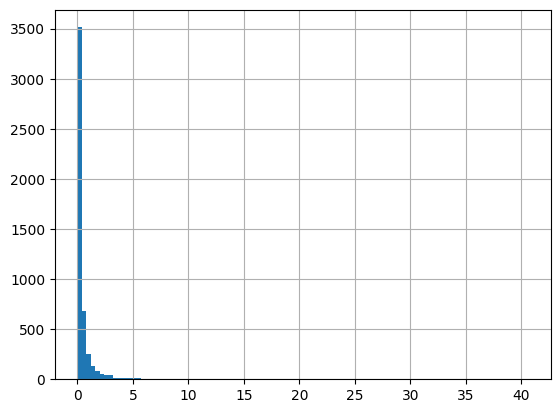

In [14]:
df_training['length'][df_training['label'] == "Noise"].hist(bins=100)
df_training['label'].value_counts()

In [15]:
def labels_for_training(s):
    if s == "Noise":
        return int(0)
    elif s == "fish":
        return int(1)
    else:
        return None
    
def basename_only(s):
    if isinstance(s, str):
        return str(os.path.basename(s))
    else:
        return s

df_training['label'] = df_training['label'].apply(labels_for_training)
df_training['annotation_source'] = df_training['annotation_source'].apply(basename_only)
df_training['filename'] = df_training['filename'].apply(basename_only)
df_training['channel'] = 1.  # this field is expected in the code
df_training.head()

,begin_time,end_time,length,low_freq,high_freq,label,annotation_source,filename,channel
0,5.434998,5.444576,0.0096,0.0,861.035,1.0,2up_20231114_0000_to_0019.Table.1.selections_f...,2up_20231114_0000_to_0019,1.0
1,5.449800,5.458507,0.0087,0.0,769.640,1.0,2up_20231114_0000_to_0019.Table.1.selections_f...,2up_20231114_0000_to_0019,1.0
2,5.468085,5.476793,0.0087,0.0,779.261,NaN,2up_20231114_0000_to_0019.Table.1.selections_f...,2up_20231114_0000_to_0019,1.0
3,7.579577,7.593508,0.0139,0.0,764.830,NaN,2up_20231114_0000_to_0019.Table.1.selections_f...,2up_20231114_0000_to_0019,1.0
4,7.818155,7.826862,0.0087,0.0,750.399,NaN,2up_20231114_0000_to_0019.Table.1.selections_f...,2up_20231114_0000_to_0019,1.0


In [16]:
df_training_shrink = df_training[["begin_time", "end_time", "filename", "length", "label", "channel"]]
df_training_shrink = df_training_shrink.rename(columns={'length': 'call_length'})
df_training_shrink.dropna(inplace=True)
df_training_shrink['label'] = df_training_shrink['label'].astype(int)

In [17]:
df_training_shrink['label'].value_counts()

0    4922
1    1486
Name: label, dtype: int64

In [18]:
## split train-val-test
train_final_df = pd.DataFrame()
val_final_df = pd.DataFrame()
test_final_df = pd.DataFrame()

for f,g in df_training_shrink.groupby('filename'):
    g = g.sort_values(by="begin_time")
    length = g.__len__()
    train_final_df = train_final_df.append(g.iloc[0:round(0.75*length)])
    val_final_df = val_final_df.append(g.iloc[round(0.75*length)+1:round(0.9*length)])
    test_final_df = test_final_df.append(g.iloc[round(0.9*length)+1:])
    print(f"for file: {f}, training data ends at {g.iloc[round(0.75*length)]['end_time']} sec")

for file: 10up_20231114_000000, training data ends at 180.906342051 sec
for file: 10up_20231114_060000, training data ends at 225.33781011 sec
for file: 1up_20231114_0000_to_0009, training data ends at 153.5331274 sec
for file: 1up_20231114_000100to00090, training data ends at 176.629363597 sec
for file: 1up_20231114_0600_to_0609_confidence, training data ends at 194.383609682 sec
for file: 20up_20231114_060000, training data ends at 136.457529844 sec
for file: 2up_20231114_0000_to_0019, training data ends at 336.976974625 sec
for file: 2up_20231114_060000_to_06090, training data ends at 232.977195043 sec
for file: 7up_20231114_000000, training data ends at 192.98664061 sec


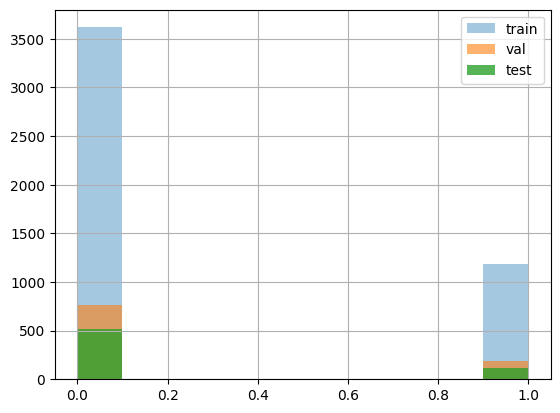

In [19]:
plt.figure()
train_final_df['label'].astype(int).hist(alpha=0.4)
val_final_df['label'].astype(int).hist(alpha=0.6)
test_final_df['label'].astype(int).hist(alpha=0.8)
plt.legend(['train', 'val','test'])
plt.show()

In [20]:
## save the training dfs
train_final_df.to_csv(os.path.join(PATH_TO_FILES, 'train_final_10jul.csv'), index=False)
val_final_df.to_csv(os.path.join(PATH_TO_FILES, 'val_final_10jul.csv'), index=False)
test_final_df.to_csv(os.path.join(PATH_TO_FILES, 'test_final_10jul.csv'), index=False)